# Tâche #1 : Classification d'incidents avec des modèles *Transformers*

On reprend, comme au premier travail, le thème de la classification de descriptions d’incidents. Cependant, la définition des classes est différente pour ce travail et de nouveaux jeux de données ont été produits. Le corpus de textes contient 3 partitions : 
-	Un fichier d’entraînement -  *data/incidents_train.json*
-	Un fichier de validation -  *data/incidents_dev.json*
-	Un fichier de test - *data/incidents_test.json*
 
Utilisez la librairie *HuggingFace* pour accomplir cette tâche. On vous demande plus spécifiquement d’utiliser 2 modèles: le modèle *bert-base-uncased* et un autre modèle de votre choix. 

Les consignes pour cette tâche sont: 
- Nom du notebook : *t1_classification.ipynb* (ce notebook)
- Tokenisation : Celle fournie par les tokeniseurs accompagnant les modèles transformers. 
- Plongements de mots : Ceux du modèle transformer. 
- Normalisation : Lettre en minuscule pour Bert (rien à faire, le tokenizer s’en occupe). Aucune contrainte pour le 2e modèle mais il est préférable de ne pas altérer le texte (sauf minuscule). 
- Choix du 2e transformer: Un modèle encodeur préentraîné pour l’anglais ou multilingue. Le modèle ne doit pas être une variante de Bert (p. ex. DistilBert). Me consulter en cas de doute.
- Entraînement : Un affinage (*fine-tuning*) du modèle, pas de préentraînement demandé (*no further pretraining*). 
- Analyse : Présentez clairement vos résultats et faites-en l’analyse. Comparez les résultats obtenus avec les 2 modèles.    

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code. 
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc. 
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle.

## 1. Création du jeu de données (*les 3 partitions du dataset*)

In [123]:
import json
def load_json_data(filename):
    with open(filename, 'r') as fp:
        data = json.load(fp)
    return data

In [124]:
# Chargement des données
incidents_train = load_json_data('data/incidents_train.json')
incidents_dev = load_json_data('data/incidents_dev.json')
incidents_test = load_json_data('data/incidents_test.json')

# Vérification de la taille des jeux de données
print("Nombre d'exemples dans le jeu d'entraînement :", len(incidents_train))
print("Nombre d'exemples dans le jeu de validation :", len(incidents_dev))
print("Nombre d'exemples dans le jeu de test :", len(incidents_test))



Nombre d'exemples dans le jeu d'entraînement : 2475
Nombre d'exemples dans le jeu de validation : 531
Nombre d'exemples dans le jeu de test : 531


In [125]:
# pour chaque type de label du jeu de données d'entraînement afficher un exemple
for label in set([incident['label'] for incident in incidents_train]):
    print("Exemple pour le label", label)
    for incident in incidents_train:
        if incident['label'] == label:
            print(incident['text'])
            break
    print()
    print()

Exemple pour le label 6
 At approximately 12:15 p.m. on February 8  2011  Employee # 1 and four other  coworkers were working in the West storage Facility at Enterprise Products  located at Mont Belvieu  Texas. A major fire began but Employee # 1 wasn't  able to escape. The recovery effort was delayed until the evening of February  10  2011  due to the presence of hydrocarbon vapors and small residual fires.   


Exemple pour le label 4
 At approximately 2:00 p.m.  on October 28  2008  Employee #1 was digging a  trench for electrical lines. The temperature was 100.7 degrees Fahrenheit and  the relative humidity was 71. Employee #1 felt cramps in his whole body and  then he collapsed. He was hospitalized for two days due to heat exhaustion.     


Exemple pour le label 7
 At approximately 1:15 p.m. on August 23  2011  Employee #1 entered a 6 ft.  trench located beside a house. He was looking at a concrete window well that  he had dug around and under. The window well broke free from the

=== Analyse des jeux de données ===


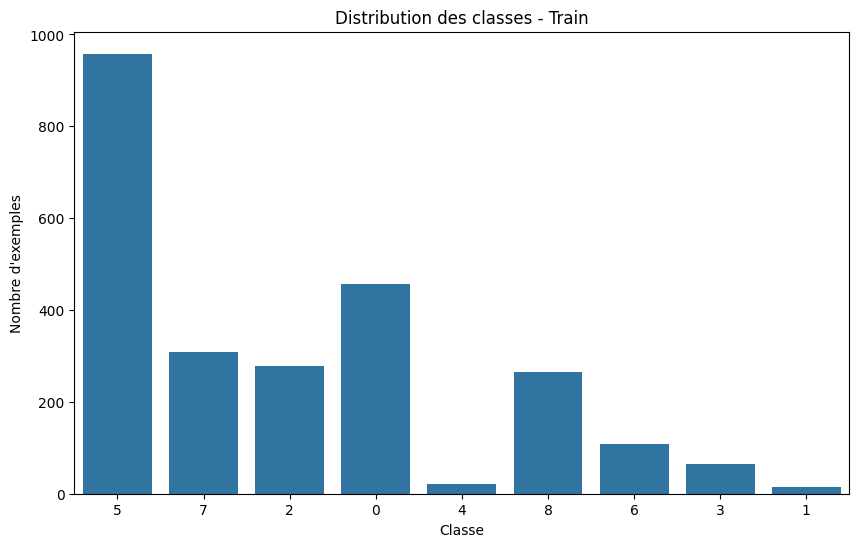

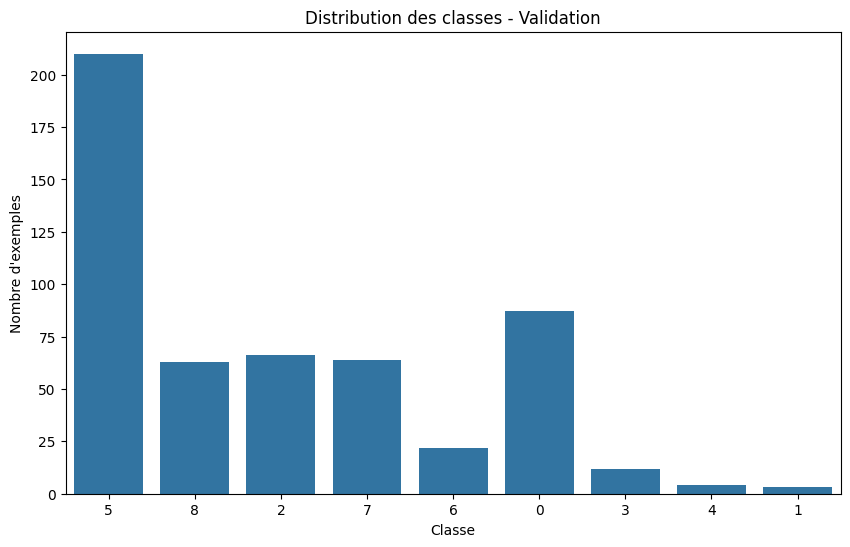

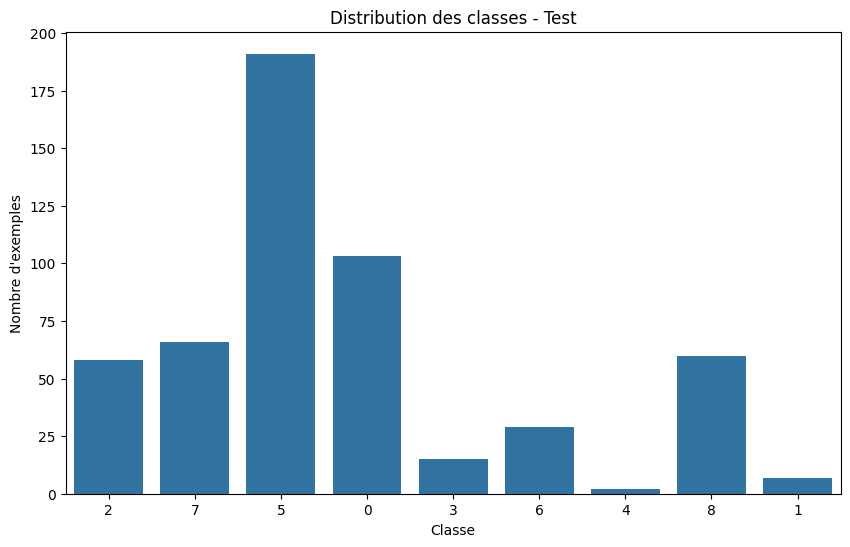


Statistiques sur les textes (jeu d'entraînement):
Longueur minimale: 8 mots
Longueur maximale: 696 mots
Longueur moyenne: 119.1 mots
Longueur médiane: 96 mots


In [126]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def analyze_dataset_distribution(dataset, title):
    """Analyse la distribution des labels dans un dataset"""
    labels = [item['label'] for item in dataset]
    counter = Counter(labels)
    
    # Créer un DataFrame pour une meilleure visualisation
    df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    df.index.name = 'label'
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df.reset_index(), x='label', y='count')
    plt.title(f'Distribution des classes - {title}')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'exemples')
    plt.show()
    
    return df

def calculate_text_statistics(dataset):
    """Calcule des statistiques sur la longueur des textes"""
    lengths = [len(item['text'].split()) for item in dataset]
    
    stats = {
        'min_length': min(lengths),
        'max_length': max(lengths),
        'avg_length': sum(lengths) / len(lengths),
        'median_length': sorted(lengths)[len(lengths)//2]
    }
    
    return stats

# Analyser les distributions
print("=== Analyse des jeux de données ===")
train_dist = analyze_dataset_distribution(incidents_train, "Train")
dev_dist = analyze_dataset_distribution(incidents_dev, "Validation")
test_dist = analyze_dataset_distribution(incidents_test, "Test")

# Statistiques sur les textes
train_stats = calculate_text_statistics(incidents_train)
print("\nStatistiques sur les textes (jeu d'entraînement):")
print(f"Longueur minimale: {train_stats['min_length']} mots")
print(f"Longueur maximale: {train_stats['max_length']} mots")
print(f"Longueur moyenne: {train_stats['avg_length']:.1f} mots")
print(f"Longueur médiane: {train_stats['median_length']} mots")

## 2. Création des 2 modèles

### 2.1 Modèle BERT


In [127]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset

class IncidentDataset(Dataset):
    """Dataset personnalisé pour les incidents"""
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self._prepare_item(self.data[idx])
    
    def _prepare_item(self, item):
        """Prépare un exemple individuel"""
        encoding = self.tokenizer(
            item['text'],
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(int(item['label']), dtype=torch.long)
        }





In [128]:
def initialize_bert_model(num_labels=9):
    """Initialise le modèle BERT et son tokenizer"""
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    return model, tokenizer

In [129]:
# Initialisation du modèle BERT
bert_model, bert_tokenizer = initialize_bert_model()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [130]:
# Création des datasets pour BERT
bert_train_dataset = IncidentDataset(incidents_train, bert_tokenizer)
bert_dev_dataset = IncidentDataset(incidents_dev, bert_tokenizer)
bert_test_dataset = IncidentDataset(incidents_test, bert_tokenizer)

### 2.2 Deuxième modèle


In [131]:
def initialize_xlm_model(num_labels=9):
    """Initialise le modèle XLM-RoBERTa et son tokenizer"""
    model_name = 'xlm-roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    return model, tokenizer





In [132]:
# Initialisation du modèle XLM-RoBERTa
xlm_model, xlm_tokenizer = initialize_xlm_model()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [133]:
# Création des datasets pour XLM-RoBERTa
xlm_train_dataset = IncidentDataset(incidents_train, xlm_tokenizer)
xlm_dev_dataset = IncidentDataset(incidents_dev, xlm_tokenizer)
xlm_test_dataset = IncidentDataset(incidents_test, xlm_tokenizer)

## 3. Entraînement des 2 modèles

In [134]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, classification_report

def create_training_args(model_name):
    """Crée les arguments d'entraînement"""
    return TrainingArguments(
        output_dir=f"./results_{model_name}",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        save_strategy="epoch",
    )

def compute_metrics(pred):
    """Calcule les métriques d'évaluation"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Récupérer le rapport de classification et le transformer en types JSON-sérialisables
    report = classification_report(labels, preds, output_dict=True)
    # Transformer seulement les valeurs qui sont des dictionnaires
    report = {label: {metric: float(value) for metric, value in metrics.items()} if isinstance(metrics, dict) 
              else float(metrics) for label, metrics in report.items()}
    
    return {
        'confusion_matrix': confusion_matrix(labels, preds).tolist(),
        'classification_report': report
    }


def train_model(model, train_dataset, eval_dataset, training_args):
    """Entraîne un modèle"""
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    return trainer


### 3.1 Modèle BERT


In [135]:
bert_training_args = create_training_args('bert')
bert_trainer = train_model(
    bert_model,
    bert_train_dataset,
    bert_dev_dataset,
    bert_training_args
)

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'eval_loss': 0.9670253992080688, 'eval_confusion_matrix': [[71, 0, 0, 0, 0, 8, 0, 7, 1], [0, 0, 0, 0, 0, 2, 0, 1, 0], [0, 0, 61, 0, 0, 4, 0, 1, 0], [1, 0, 1, 5, 0, 1, 1, 3, 0], [0, 0, 1, 1, 0, 0, 1, 1, 0], [11, 0, 2, 0, 0, 188, 0, 9, 0], [1, 0, 8, 0, 0, 0, 9, 3, 1], [12, 0, 6, 0, 0, 6, 4, 35, 1], [31, 0, 1, 1, 0, 7, 1, 13, 9]], 'eval_classification_report': {'0': {'precision': 0.5590551181102362, 'recall': 0.8160919540229885, 'f1-score': 0.6635514018691588, 'support': 87.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '2': {'precision': 0.7625, 'recall': 0.9242424242424242, 'f1-score': 0.8356164383561644, 'support': 66.0}, '3': {'precision': 0.7142857142857143, 'recall': 0.4166666666666667, 'f1-score': 0.5263157894736842, 'support': 12.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '5': {'precision': 0.8703703703703703, 'recall': 0.8952380952380953, 'f1-score': 0.8826291079812206, 'support': 210.0}, '6': {'precision': 0.5625, 

  0%|          | 0/34 [00:00<?, ?it/s]

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'eval_loss': 0.8391035199165344, 'eval_confusion_matrix': [[60, 0, 0, 0, 0, 5, 0, 13, 9], [0, 0, 0, 0, 0, 2, 0, 1, 0], [0, 0, 61, 0, 0, 4, 0, 1, 0], [0, 0, 1, 5, 0, 1, 3, 2, 0], [0, 0, 1, 1, 0, 0, 1, 1, 0], [6, 0, 0, 0, 0, 186, 2, 8, 8], [0, 0, 5, 0, 0, 0, 15, 2, 0], [5, 0, 4, 0, 0, 5, 5, 36, 9], [7, 0, 1, 0, 0, 5, 4, 8, 38]], 'eval_classification_report': {'0': {'precision': 0.7692307692307693, 'recall': 0.6896551724137931, 'f1-score': 0.7272727272727273, 'support': 87.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '2': {'precision': 0.8356164383561644, 'recall': 0.9242424242424242, 'f1-score': 0.8776978417266187, 'support': 66.0}, '3': {'precision': 0.8333333333333334, 'recall': 0.4166666666666667, 'f1-score': 0.5555555555555556, 'support': 12.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '5': {'precision': 0.8942307692307693, 'recall': 0.8857142857142857, 'f1-score': 0.8899521531100478, 'support': 210.0}, '6': {'precision

  0%|          | 0/34 [00:00<?, ?it/s]

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'eval_loss': 0.7750293612480164, 'eval_confusion_matrix': [[65, 0, 0, 0, 0, 7, 0, 8, 7], [0, 0, 0, 0, 0, 2, 0, 1, 0], [0, 0, 61, 0, 0, 4, 0, 1, 0], [0, 0, 1, 6, 0, 1, 3, 1, 0], [0, 0, 1, 1, 0, 0, 1, 1, 0], [8, 0, 0, 1, 0, 188, 1, 7, 5], [0, 0, 5, 1, 0, 0, 12, 2, 2], [6, 0, 2, 0, 0, 5, 5, 36, 10], [16, 0, 1, 0, 0, 7, 3, 5, 31]], 'eval_classification_report': {'0': {'precision': 0.6842105263157895, 'recall': 0.7471264367816092, 'f1-score': 0.7142857142857143, 'support': 87.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '2': {'precision': 0.8591549295774648, 'recall': 0.9242424242424242, 'f1-score': 0.8905109489051095, 'support': 66.0}, '3': {'precision': 0.6666666666666666, 'recall': 0.5, 'f1-score': 0.5714285714285714, 'support': 12.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '5': {'precision': 0.8785046728971962, 'recall': 0.8952380952380953, 'f1-score': 0.8867924528301887, 'support': 210.0}, '6': {'precision': 0.48, 'reca

### 3.2 Deuxième modèle


In [136]:
xlm_training_args = create_training_args('xlm')
xlm_trainer = train_model(
    xlm_model,
    xlm_train_dataset,
    xlm_dev_dataset,
    xlm_training_args
)

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'eval_loss': 1.0984165668487549, 'eval_confusion_matrix': [[56, 0, 0, 0, 0, 10, 0, 21, 0], [0, 0, 0, 0, 0, 2, 0, 1, 0], [2, 0, 60, 0, 0, 4, 0, 0, 0], [0, 0, 4, 0, 0, 1, 0, 7, 0], [0, 0, 1, 0, 0, 1, 0, 2, 0], [15, 0, 2, 0, 0, 185, 0, 8, 0], [1, 0, 11, 0, 0, 1, 0, 9, 0], [11, 0, 10, 0, 0, 9, 0, 34, 0], [26, 0, 4, 0, 0, 19, 0, 14, 0]], 'eval_classification_report': {'0': {'precision': 0.5045045045045045, 'recall': 0.6436781609195402, 'f1-score': 0.5656565656565656, 'support': 87.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '2': {'precision': 0.6521739130434783, 'recall': 0.9090909090909091, 'f1-score': 0.759493670886076, 'support': 66.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '5': {'precision': 0.7974137931034483, 'recall': 0.8809523809523809, 'f1-score': 0.8371040723981901, 'support': 210.0}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 

  0%|          | 0/34 [00:00<?, ?it/s]

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'eval_loss': 0.9859966039657593, 'eval_confusion_matrix': [[56, 0, 0, 0, 0, 10, 0, 19, 2], [0, 0, 0, 0, 0, 2, 0, 1, 0], [2, 0, 60, 0, 0, 4, 0, 0, 0], [0, 0, 1, 0, 0, 1, 5, 5, 0], [0, 0, 1, 0, 0, 0, 2, 1, 0], [10, 0, 1, 0, 0, 180, 1, 14, 4], [1, 0, 4, 0, 0, 1, 14, 2, 0], [10, 0, 6, 0, 0, 5, 3, 38, 2], [28, 0, 1, 0, 0, 11, 0, 20, 3]], 'eval_classification_report': {'0': {'precision': 0.5233644859813084, 'recall': 0.6436781609195402, 'f1-score': 0.5773195876288659, 'support': 87.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '2': {'precision': 0.8108108108108109, 'recall': 0.9090909090909091, 'f1-score': 0.8571428571428571, 'support': 66.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '5': {'precision': 0.8411214953271028, 'recall': 0.8571428571428571, 'f1-score': 0.8490566037735849, 'support': 210.0}, '6': {'precision': 0.56, 'recall': 0.6363636363636364, 

  0%|          | 0/34 [00:00<?, ?it/s]

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'eval_loss': 0.9646221399307251, 'eval_confusion_matrix': [[68, 0, 0, 0, 0, 9, 1, 8, 1], [0, 0, 0, 0, 0, 2, 0, 1, 0], [2, 0, 60, 0, 0, 4, 0, 0, 0], [0, 0, 1, 0, 0, 2, 4, 5, 0], [0, 0, 1, 0, 0, 0, 2, 1, 0], [15, 0, 1, 0, 0, 183, 1, 9, 1], [1, 0, 4, 0, 0, 1, 15, 1, 0], [9, 0, 6, 0, 0, 10, 8, 29, 2], [29, 0, 0, 0, 0, 13, 0, 16, 5]], 'eval_classification_report': {'0': {'precision': 0.5483870967741935, 'recall': 0.7816091954022989, 'f1-score': 0.6445497630331753, 'support': 87.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '2': {'precision': 0.821917808219178, 'recall': 0.9090909090909091, 'f1-score': 0.8633093525179856, 'support': 66.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '5': {'precision': 0.8169642857142857, 'recall': 0.8714285714285714, 'f1-score': 0.8433179723502304, 'support': 210.0}, '6': {'precision': 0.4838709677419355, 'recall': 0.68181818

## 4. Évaluation, analyse de résultats et comparaison des 2 modèles

  0%|          | 0/34 [00:00<?, ?it/s]

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

  0%|          | 0/34 [00:00<?, ?it/s]

c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

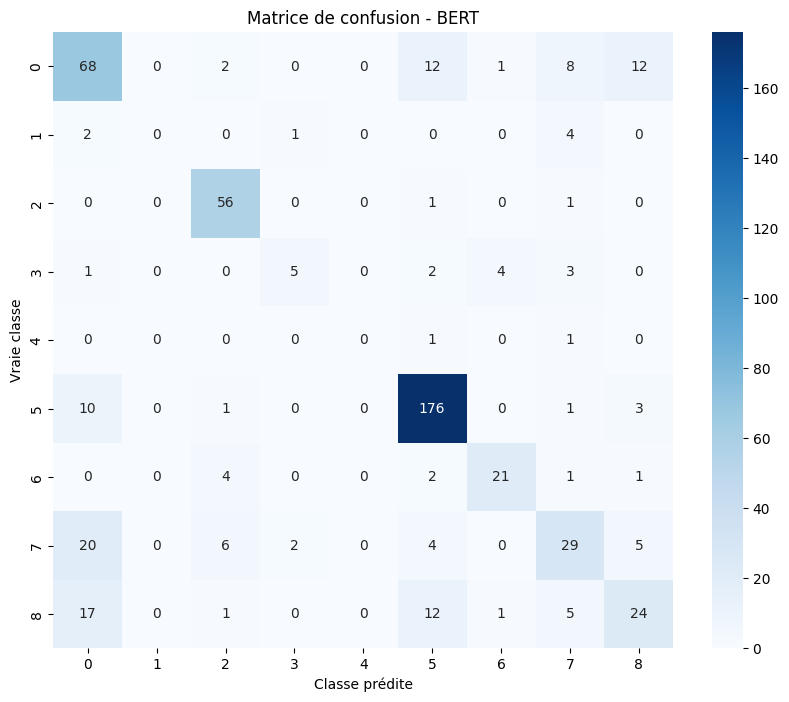

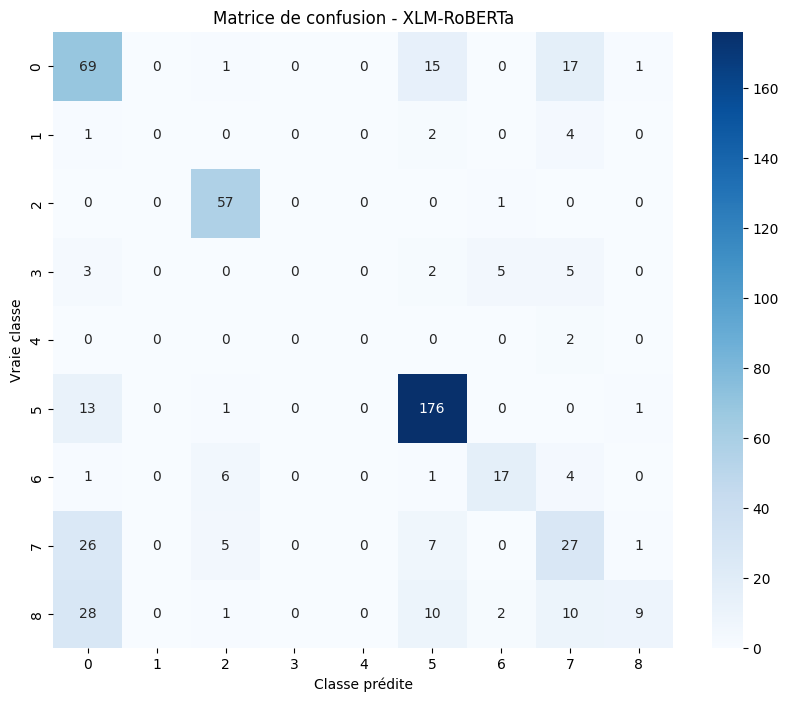

=== Métriques globales ===

accuracy:
BERT: 0.714
XLM-RoBERTa: 0.669

macro avg:
BERT: 0.500
XLM-RoBERTa: 0.400

weighted avg:
BERT: 0.696
XLM-RoBERTa: 0.632

=== F1-Score par classe ===

Classe 0:
BERT: 0.615
XLM-RoBERTa: 0.566

Classe 1:
BERT: 0.000
XLM-RoBERTa: 0.000

Classe 2:
BERT: 0.875
XLM-RoBERTa: 0.884

Classe 3:
BERT: 0.435
XLM-RoBERTa: 0.000

Classe 4:
BERT: 0.000
XLM-RoBERTa: 0.000

Classe 5:
BERT: 0.878
XLM-RoBERTa: 0.871

Classe 6:
BERT: 0.750
XLM-RoBERTa: 0.630

Classe 7:
BERT: 0.487
XLM-RoBERTa: 0.400

Classe 8:
BERT: 0.457
XLM-RoBERTa: 0.250


In [137]:
def plot_confusion_matrix(cm, title):
    """Visualise une matrice de confusion"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()

def compare_models_performance(bert_results, xlm_results):
    """Compare les performances des deux modèles"""
    bert_report = bert_results['eval_classification_report']
    xlm_report = xlm_results['eval_classification_report']
    
    # Métriques globales
    print("=== Métriques globales ===")
    metrics = ['accuracy', 'macro avg', 'weighted avg']
    for metric in metrics:
        print(f"\n{metric}:")
        if metric == 'accuracy':
            print(f"BERT: {bert_report[metric]:.3f}")
            print(f"XLM-RoBERTa: {xlm_report[metric]:.3f}")
        else:
            print(f"BERT: {bert_report[metric]['f1-score']:.3f}")
            print(f"XLM-RoBERTa: {xlm_report[metric]['f1-score']:.3f}")
    
    # Métriques par classe
    print("\n=== F1-Score par classe ===")
    for i in range(9):
        print(f"\nClasse {i}:")
        print(f"BERT: {bert_report[str(i)]['f1-score']:.3f}")
        print(f"XLM-RoBERTa: {xlm_report[str(i)]['f1-score']:.3f}")

# Évaluation sur le jeu de test
bert_test_results = bert_trainer.evaluate(bert_test_dataset)
xlm_test_results = xlm_trainer.evaluate(xlm_test_dataset)

# Visualisation des matrices de confusion
plot_confusion_matrix(
    bert_test_results['eval_confusion_matrix'],
    'Matrice de confusion - BERT'
)
plot_confusion_matrix(
    xlm_test_results['eval_confusion_matrix'],
    'Matrice de confusion - XLM-RoBERTa'
)

# Comparaison des performances
compare_models_performance(bert_test_results, xlm_test_results)